In the preprocessing section, we extracted the raw location records and stored them into MongoDB. Further, we removed outlier, and applied segmentation and interpolation for cleaning the location records and taking the GPS outage into consideration. With this, we can now use these filtered location records for our first application of *Automatic bus-stop detection*. The bus-stop detection uses unsupervised clustering based algorithm to detect stoppages on a route. We firstly describe the algorithm and then describe it's application for bus-stop detection.

## DBSCAN algorithm

Density-Based Spatial Clustering of Applications with Noise (DBSCAN) [1] is the data clustering algorithm which can detect clusters of arbitary shapes in the data-set. 

### Steps to find cluster in a data-set

1. Find the points in the <span style="color:blue">**{$\varepsilon$} (eps)**</span> neighborhood of every point
2. Mark core points if more than <span style="color:blue">**minPts**</span> 
3. Identify connected neighbor points with the core points
4. If point is not in the neighborhood of core point mark it as a noise
5. Repeat step 1-4 for unvisited data point

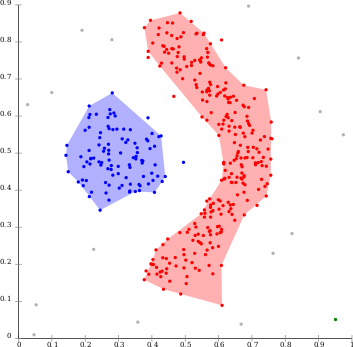 DBSCAN clustring algorithm [2]

## DBCAN based bus-stop detection
The idea behind using DBSCAN based clustering algorithm is as follow: A bus follows a ***stop-and-go*** pattern during its trip. When a bus is in motion, the periodic data points are separated from one another by certain distance. For example, in a typical urban scenario, during peak hours the average movement speed of a bus is 12-15 km/hr [3] in metropolitan cities of India. At this speed the successive data points (published by bus module) would be separated by 3-4 meters. When a bus is stopped at a bus-stop or at a junction (due to red signal or congestion), the periodic location data points (published by bus module) are clustered at the same location. 

We have set the  value of <span style="color:blue">$eps =  \bar{ac} + 2 \times \sigma_{ac}$</span>. The bus module application sends the location update every second. Hence, if we consider the condition of normality on our filtered location records (>30 location records), then 95% of location record would have an accuracy within the range of *eps*. Thus when a bus is *stopped* a location record of bus would be in the *eps* periphery of point. 

Now, varying <span style="color:blue">***minPts***</span> would led us to obtain different types of stoppages. For instance, by setting $minPts=4$ would led us to extract all the stoppages on a route including stoppages due to speed breaker or pothole. In the following, we would execute the interactive code for detecting bus stop on a route using filtered location records and play around with it.

We will extract the filtered trip records of morning trip from MongoDB database by querying *TripInfo* for status `filteredLocationRecord:True` and trip start time of *07* hours. Subsequently, we shall utilize the `meanAccuracy` and `stdAccuracy` computed using `Preprocessing.ApplyFiltering` in the section of *Preprocessing* for calculating *eps* value.

In [1]:
'''Imports '''
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from pymongo import MongoClient
import pprint
import numpy as np
import sys
import os
from sklearn.cluster import DBSCAN
import folium

In [2]:
sys.path.append("/".join(os.getcwd().split('/')) +'/Codes/LibCodes')
import StoppageDetection

In [3]:
'''For updating the lib changes effects'''
import importlib
importlib.reload(StoppageDetection)

<module 'StoppageDetection' from '/home/pruthvish/JRF/GitVersionICDCN/Codes/LibCodes/StoppageDetection.py'>

In [4]:
'''Initialize MongoClient'''
con = MongoClient()

RouteName='Git_ISCON_PDPU'

SingleTripsInfo = [rec['SingleTripInfo'] for rec in con[RouteName]['TripInfo'].find({'$and': 
                                                                   [ {'filteredLocationRecord':True}, 
                                                                    {'TripStartHour':'07'} ] })]

'''List down the trips extracted from the above query'''
print([rec for rec in SingleTripsInfo])

['29_01_2018__07_39_47', '30_01_2018__07_42_30', '01_02_2018__07_39_12', '02_02_2018__07_38_50', '18_01_2018__07_38_10', '19_01_2018__07_38_47', '22_01_2018__07_41_04', '22_12_2017__07_38_21', '26_12_2017__07_32_35', '20_12_2017__07_38_14', '21_12_2017__07_52_59', '08_01_2018__07_41_43', '09_01_2018__07_40_01', '27_12_2017__07_55_48', '29_12_2017__07_37_27', '01_01_2018__07_38_27', '12_02_2018__07_40_14', '15_02_2018__07_45_52', '16_02_2018__07_45_41', '19_02_2018__07_46_19', '20_02_2018__07_41_48', '21_02_2018__07_42_42', '13_03_2018__07_29_52', '14_03_2018__07_35_46', '20_03_2018__07_28_45', '21_03_2018__07_32_39', '22_03_2018__07_38_43', '14_02_2018__07_41_04', '22_02_2018__07_42_45', '12_02_2018__07_40_14', '15_02_2018__07_45_52', '16_02_2018__07_45_41', '19_02_2018__07_46_19', '20_02_2018__07_41_48', '21_02_2018__07_42_42', '13_03_2018__07_29_52', '14_03_2018__07_35_46', '20_03_2018__07_28_45', '21_03_2018__07_32_39', '22_03_2018__07_38_43', '14_02_2018__07_41_04', '22_02_2018__07

In [5]:
def PerformDBSCAN(TripIndex, minPts):
    '''
    input: 
    output: 
    function: 
    '''
    print(SingleTripsInfo[TripIndex],minPts)
    LocationRecord = [rec for rec in con [RouteName] [SingleTripsInfo[TripIndex]
                                                      +'.Filtered'].find().sort([('epoch',1)]) ]
    
    meanAccuracy = [rec['meanAccuracy'] for
                    rec in con[RouteName]['TripInfo'].find({'SingleTripInfo':SingleTripsInfo[TripIndex] })][0]

    stdAccuracy = [rec['stdAccuracy'] for
                    rec in con[RouteName]['TripInfo'].find({'SingleTripInfo':SingleTripsInfo[TripIndex]})][0]

    
    epsForDetection = meanAccuracy + 2 * stdAccuracy
    
    map_osm = StoppageDetection.InitializeMap(LocationRecord)
    
    LocationTupleList = np.asarray([(rec['Latitude'],rec['Longitude']) 
                         for rec in LocationRecord])
    
    print(epsForDetection,type(epsForDetection))
    model = DBSCAN(eps=epsForDetection, min_samples=minPts, metric=StoppageDetection.mydistance).fit(LocationTupleList) 
    
    clusters=np.amax(model.labels_)+1
    
    map_osm = StoppageDetection.MarkBusStopOnAMap(LocationTupleList, model, clusters, LocationRecord, map_osm)
    
    return(map_osm)

Now from these trip for interactive demo of DBCSCAN based bus-stop detection, we will use any one trip from the `SingleTripsInfo`. Let say we choose first trip `29_01_2018__07_39_47` i.e the trip with index 0. (One can choose any of the trip) and change the value of *minPts* and observe the output of DBSCAN algortihm on a map.

In [6]:
index = widgets.Dropdown(options =[(SingleTripInfo,index) for index,SingleTripInfo in enumerate(SingleTripsInfo)],
                                  value=0, 
                                  description = 'Select trip' )

In [7]:
minPts = widgets.IntSlider (min=1, max=15, value=4, description='minPts')

In [8]:
interact (PerformDBSCAN, TripIndex = index, minPts = minPts)

interactive(children=(Dropdown(description='Select trip', options=(('29_01_2018__07_39_47', 0), ('30_01_2018__…

<function __main__.PerformDBSCAN(TripIndex, minPts)>

# References:
* [1] Martin Ester, Hans-Peter Kriegel, Jorg Sander, and Xiaowei Xu. August, 1996. A density-based algorithm for discovering clusters a density-based algorithm for discovering clusters in large spatial databases with noise. 2nd ACM conference on International Conference on Knowledge Discovery and Data Mining (KDD) (August, 1996), 226–231.
* [2] W. Commons”, “”file:dbscan-density-data.svg — wikimedia commons, the free media repository”,” ”2011”, ”[Online;
accessed 30-April-2019]”
* [3] 2011. Bangalore Mobility Indicators 2010-11. Urban Mass Transit Company Limited (UMTC) (2011)
 